In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, classification_report,
                             roc_curve, auc)

from scipy.stats import randint, uniform

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import warnings
warnings.filterwarnings('ignore')

matplotlib.rcParams['font.family'] = 'DejaVu Sans'


In [2]:
# ------ 1. 데이터 로드 및 기본 처리 ------
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.csv"
column_names = ['n_Pregnancies', 'Glucose_Concentration', 'Blood_Pressure(mmHg)',
                'Skin_Thickness(mm)', 'Serum_Insulin(mu_U/ml)', 'BMI',
                'Diabetes_Pedigree_Function', 'Age', 'Outcome']

df = pd.read_csv(url, names=column_names)

In [3]:
# ------ 2. 0값을 결측치로 변환 ------
columns_with_zeros = ['Glucose_Concentration', 'Blood_Pressure(mmHg)', 'Skin_Thickness(mm)',
                      'Serum_Insulin(mu_U/ml)', 'BMI']
for col in columns_with_zeros:
    df[col] = df[col].replace(0, np.nan)

In [4]:
# ------ 3. 데이터 분할 ------
data = df[df.columns[:-1]]
target = df['Outcome']

train_input, test_input, train_target, test_target = train_test_split(
    data, target, stratify=target, test_size=0.2, random_state=42
)

In [5]:
# ------ 4. 결측치 처리 - SimpleImputer 사용 (Median) ------
imputer = SimpleImputer(strategy='median')
imputer.fit(train_input)

train_input_imputed = pd.DataFrame(imputer.transform(train_input), columns=train_input.columns, index=train_input.index)
test_input_imputed = pd.DataFrame(imputer.transform(test_input), columns=test_input.columns, index=test_input.index)


In [6]:
# ------ 5. 파생 변수 생성 ------
train_input_imputed['BMI_Age'] = train_input_imputed['BMI'] * train_input_imputed['Age']
test_input_imputed['BMI_Age'] = test_input_imputed['BMI'] * test_input_imputed['Age']

train_input_imputed['Age_Pregnancies_ratio'] = train_input_imputed['Age'] / (train_input_imputed['n_Pregnancies'] + 1)
test_input_imputed['Age_Pregnancies_ratio'] = test_input_imputed['Age'] / (test_input_imputed['n_Pregnancies'] + 1)


In [7]:
# ------ 6. 표준화 (Logistic Regression에만 적용) ------
scaler = StandardScaler()
scaler.fit(train_input_imputed)
train_scaled = scaler.transform(train_input_imputed)
test_scaled = scaler.transform(test_input_imputed)


In [8]:
# ------ 7. 평가 함수 정의 (모든 메트릭 반환) ------
def evaluate_model(model, train_data, train_labels, test_data, test_labels, model_name):
    print("\n" + "="*60)
    print(f"모델: {model_name}")
    print("="*60)
    
    y_pred = model.predict(test_data)
    y_pred_proba = model.predict_proba(test_data)[:, 1] if hasattr(model, 'predict_proba') else None

    train_score = model.score(train_data, train_labels)
    test_score = model.score(test_data, test_labels)
    acc = accuracy_score(test_labels, y_pred)
    prec = precision_score(test_labels, y_pred)
    rec = recall_score(test_labels, y_pred)
    f1 = f1_score(test_labels, y_pred)
    roc = roc_auc_score(test_labels, y_pred_proba) if y_pred_proba is not None else None

    print(f"훈련 정확도: {train_score:.4f}  |  테스트 정확도: {test_score:.4f}")
    print(f"정밀도: {prec:.4f}  |  재현율: {rec:.4f}  |  F1: {f1:.4f}")
    
    if roc is not None:
        print(f"ROC-AUC: {roc:.4f}")

    print("\n혼동행렬:")
    print(confusion_matrix(test_labels, y_pred))
    print("\n분류 보고서:")
    print(classification_report(test_labels, y_pred))

    if y_pred_proba is not None:
        plt.figure(figsize=(8,6))
        fpr, tpr, _ = roc_curve(test_labels, y_pred_proba)
        plt.plot(fpr, tpr, label=f'ROC Curve (AUC={auc(fpr,tpr):.4f})', color='blue')
        plt.plot([0,1], [0,1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{model_name} - ROC Curve')
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

    return {
        'model_name': model_name,
        'train_score': train_score,
        'test_score': test_score,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'roc_auc': roc
    }

results = []



모델 1: Logistic Regression 학습 중...
최적 파라미터: {'C': 0.5818361216819946, 'class_weight': 'balanced'}
CV F1 스코어: 0.6751

모델: LogReg
훈련 정확도: 0.7704  |  테스트 정확도: 0.7338
정밀도: 0.6000  |  재현율: 0.7222  |  F1: 0.6555
ROC-AUC: 0.8100

혼동행렬:
[[74 26]
 [15 39]]

분류 보고서:
              precision    recall  f1-score   support

           0       0.83      0.74      0.78       100
           1       0.60      0.72      0.66        54

    accuracy                           0.73       154
   macro avg       0.72      0.73      0.72       154
weighted avg       0.75      0.73      0.74       154



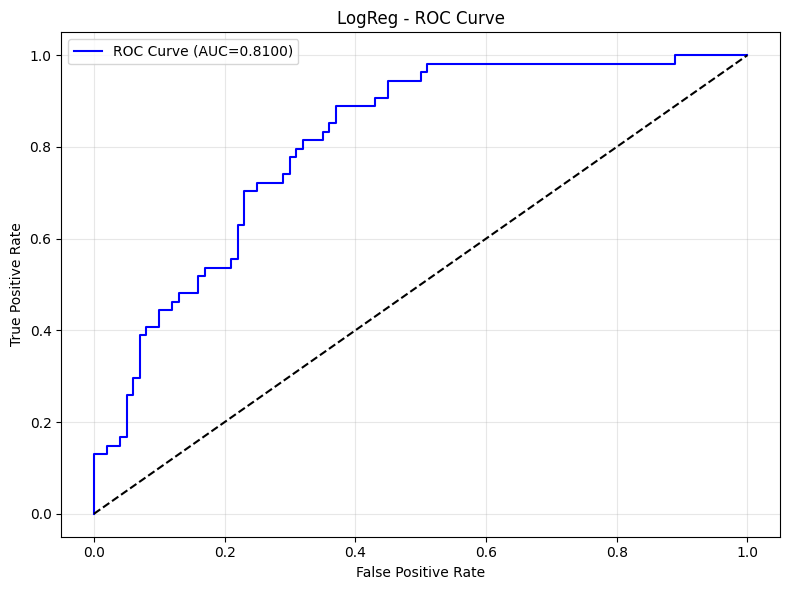

In [9]:
# ------ 8. 모델별 하이퍼파라미터 탐색 및 평가 ------

# 8-1. Logistic Regression (class_weight 포함, f1 기준 튜닝)
print("\n" + "="*60)
print("모델 1: Logistic Regression 학습 중...")
print("="*60)

param_dist_lr = {
    'C': uniform(0.001, 10),
    'class_weight': [None, 'balanced']
}

lr_search = RandomizedSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    param_distributions=param_dist_lr,
    n_iter=30,  # 80 → 30 (속도 향상)
    cv=3,       # 5 → 3 (속도 향상)
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=0
)

lr_search.fit(train_scaled, train_target)
print(f"최적 파라미터: {lr_search.best_params_}")
print(f"CV F1 스코어: {lr_search.best_score_:.4f}")

best_lr = lr_search.best_estimator_
results.append(evaluate_model(best_lr, train_scaled, train_target, test_scaled, test_target, "LogReg"))



모델 2: Random Forest 학습 중...
최적 파라미터: {'class_weight': 'balanced_subsample', 'max_depth': 8, 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 12, 'n_estimators': 337}
CV F1 스코어: 0.6799

모델: RF
훈련 정확도: 0.8795  |  테스트 정확도: 0.7208
정밀도: 0.5873  |  재현율: 0.6852  |  F1: 0.6325
ROC-AUC: 0.8161

혼동행렬:
[[74 26]
 [17 37]]

분류 보고서:
              precision    recall  f1-score   support

           0       0.81      0.74      0.77       100
           1       0.59      0.69      0.63        54

    accuracy                           0.72       154
   macro avg       0.70      0.71      0.70       154
weighted avg       0.73      0.72      0.72       154



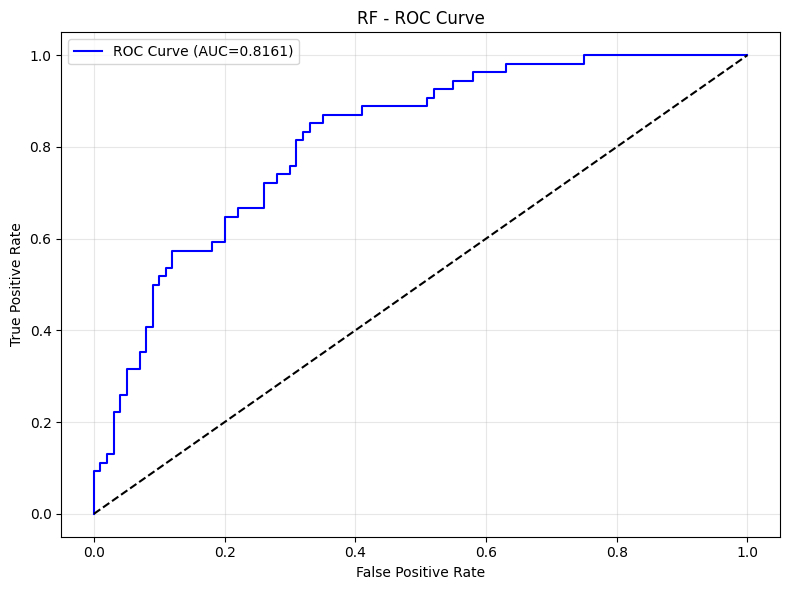

In [10]:
# 8-2. Random Forest (class_weight 포함)
print("\n" + "="*60)
print("모델 2: Random Forest 학습 중...")
print("="*60)

param_dist_rf = {
    'n_estimators': randint(150, 400),
    'max_depth': randint(4, 15),
    'min_samples_split': randint(4, 20),
    'min_samples_leaf': randint(2, 10),
    'max_features': ['sqrt', 'log2'],
    'class_weight': [None, 'balanced', 'balanced_subsample']
}

rf_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=1),  # n_jobs=1로 변경
    param_distributions=param_dist_rf,
    n_iter=30,  # 60 → 30 (속도 향상)
    cv=3,       # 5 → 3 (속도 향상)
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=0
)

rf_search.fit(train_input_imputed, train_target)
print(f"최적 파라미터: {rf_search.best_params_}")
print(f"CV F1 스코어: {rf_search.best_score_:.4f}")

best_rf = rf_search.best_estimator_
results.append(evaluate_model(best_rf, train_input_imputed, train_target, test_input_imputed, test_target, "RF"))



모델 3: Random Forest + SMOTE 학습 중...
최적 파라미터: {'rf__class_weight': 'balanced', 'rf__max_depth': 5, 'rf__min_samples_leaf': 9, 'rf__n_estimators': 281}
CV F1 스코어: 0.6838

모델: RF+SMOTE
훈련 정확도: 0.8062  |  테스트 정확도: 0.7403
정밀도: 0.5972  |  재현율: 0.7963  |  F1: 0.6825
ROC-AUC: 0.8270

혼동행렬:
[[71 29]
 [11 43]]

분류 보고서:
              precision    recall  f1-score   support

           0       0.87      0.71      0.78       100
           1       0.60      0.80      0.68        54

    accuracy                           0.74       154
   macro avg       0.73      0.75      0.73       154
weighted avg       0.77      0.74      0.75       154



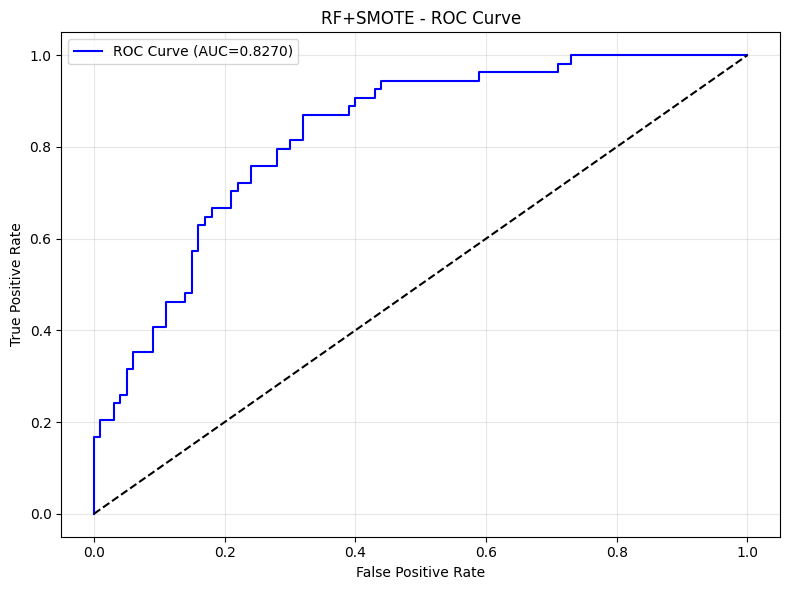

In [ ]:
# 8-3. Random Forest + SMOTE (파이프라인으로 안전하게 적용)
print("\n" + "="*60)
print("모델 3: Random Forest + SMOTE 학습 중...")
print("="*60)

# imblearn Pipeline으로 SMOTE를 교차검증 내부에 포함
rf_smote_pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42, k_neighbors=5)),
    ('rf', RandomForestClassifier(random_state=42, n_jobs=1))
])

param_dist_rf_smote = {
    'rf__n_estimators': randint(150, 400),
    'rf__max_depth': randint(4, 15),
    'rf__min_samples_leaf': randint(2, 10),
    'rf__class_weight': [None, 'balanced']
}

rf_smote_search = RandomizedSearchCV(
    rf_smote_pipeline,
    param_distributions=param_dist_rf_smote,
    n_iter=30,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=0
)

# SMOTE는 훈련 데이터에만 적용
rf_smote_search.fit(train_input_imputed, train_target)
print(f"최적 파라미터: {rf_smote_search.best_params_}")
print(f"CV F1 스코어: {rf_smote_search.best_score_:.4f}")

best_rf_smote = rf_smote_search.best_estimator_
# 평가할 때는 테스트는 원본 데이터로 (SMOTE 미적용)
results.append(evaluate_model(best_rf_smote, train_input_imputed, train_target, test_input_imputed, test_target, "RF+SMOTE"))



모델 4: LightGBM 학습 중...


최적 파라미터: {'num_leaves': 24, 'n_estimators': 100, 'min_child_samples': 40, 'max_depth': 6, 'learning_rate': 0.05}
CV F1 스코어: 0.6381

모델: LightGBM
훈련 정확도: 0.8860  |  테스트 정확도: 0.7532
정밀도: 0.6538  |  재현율: 0.6296  |  F1: 0.6415
ROC-AUC: 0.8219

혼동행렬:
[[82 18]
 [20 34]]

분류 보고서:
              precision    recall  f1-score   support

           0       0.80      0.82      0.81       100
           1       0.65      0.63      0.64        54

    accuracy                           0.75       154
   macro avg       0.73      0.72      0.73       154
weighted avg       0.75      0.75      0.75       154



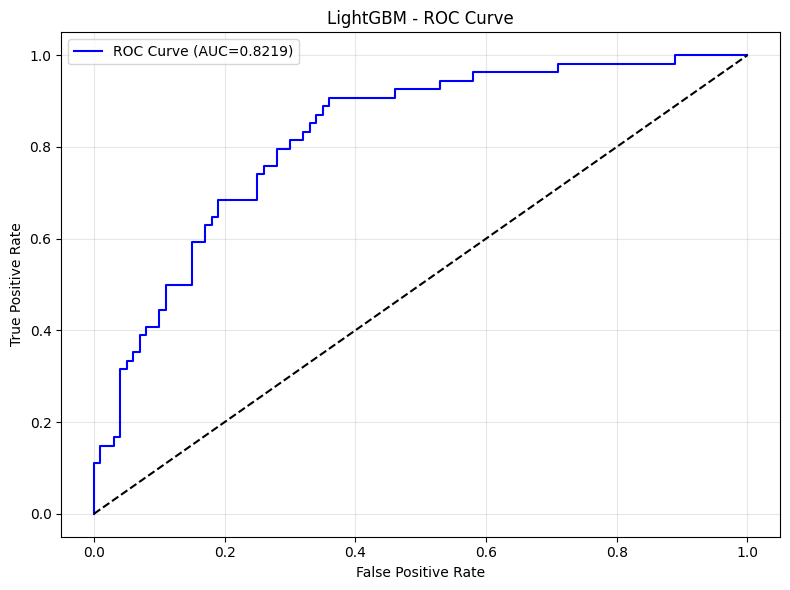

In [13]:
# 8-4. LightGBM (cv=3, f1 기준)
print("\n" + "="*60)
print("모델 4: LightGBM 학습 중...")
print("="*60)

param_dist_lgb = {
    'n_estimators': [100, 120, 150],
    'learning_rate': [0.05, 0.08, 0.1],
    'num_leaves': [24, 31],
    'max_depth': [5, 6],
    'min_child_samples': [40, 50]
}

lgb_search = RandomizedSearchCV(
    LGBMClassifier(random_state=42, verbose=-1, n_jobs=-1, subsample=0.8, colsample_bytree=0.8),
    param_distributions=param_dist_lgb,
    n_iter=10,
    cv=3,       # 5 → 3 (속도 향상)
    scoring='f1',
    n_jobs=-1,
    random_state=42
)

lgb_search.fit(train_input_imputed, train_target)
print(f"최적 파라미터: {lgb_search.best_params_}")
print(f"CV F1 스코어: {lgb_search.best_score_:.4f}")

best_lgb = lgb_search.best_estimator_
results.append(evaluate_model(best_lgb, train_input_imputed, train_target, test_input_imputed, test_target, "LightGBM"))



모델 5: XGBoost 학습 중...


최적 파라미터: {'colsample_bytree': 0.8032795106962874, 'gamma': 3.479064033954409, 'learning_rate': 0.09583588048137198, 'max_depth': 6, 'min_child_weight': 4, 'n_estimators': 246, 'reg_alpha': 1.4222990648760356, 'reg_lambda': 1.6190020922794308, 'scale_pos_weight': 1.8691588785046729, 'subsample': 0.7394663949166917}
CV F1 스코어: 0.6950

모델: XGBoost
훈련 정확도: 0.8339  |  테스트 정확도: 0.7143
정밀도: 0.5714  |  재현율: 0.7407  |  F1: 0.6452
ROC-AUC: 0.8222

혼동행렬:
[[70 30]
 [14 40]]

분류 보고서:
              precision    recall  f1-score   support

           0       0.83      0.70      0.76       100
           1       0.57      0.74      0.65        54

    accuracy                           0.71       154
   macro avg       0.70      0.72      0.70       154
weighted avg       0.74      0.71      0.72       154



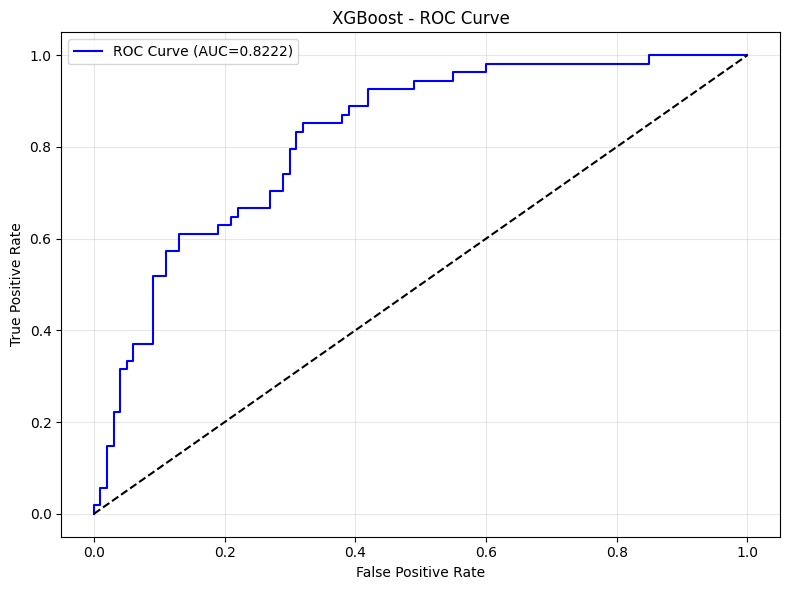

In [14]:
# 8-5. XGBoost (scale_pos_weight 포함)
print("\n" + "="*60)
print("모델 5: XGBoost 학습 중...")
print("="*60)

pos = train_target.sum()
neg = len(train_target) - pos
scale_pos = neg / pos

param_dist_xgb = {
    'n_estimators': randint(100, 300),
    'learning_rate': uniform(0.01, 0.1),
    'max_depth': randint(3, 8),
    'min_child_weight': randint(1, 10),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 5),
    'reg_alpha': uniform(0, 2),
    'reg_lambda': uniform(0, 2),
    'scale_pos_weight': [scale_pos]
}

xgb_search = RandomizedSearchCV(
    XGBClassifier(random_state=42, verbosity=0, tree_method='hist'),
    param_distributions=param_dist_xgb,
    n_iter=30,  # 60 → 30 (속도 향상)
    cv=3,       # 5 → 3 (속도 향상)
    scoring='f1',
    n_jobs=-1,
    random_state=42
)

xgb_search.fit(train_input_imputed, train_target)
print(f"최적 파라미터: {xgb_search.best_params_}")
print(f"CV F1 스코어: {xgb_search.best_score_:.4f}")

best_xgb = xgb_search.best_estimator_
results.append(evaluate_model(best_xgb, train_input_imputed, train_target, test_input_imputed, test_target, "XGBoost"))



최종 모델 성능 비교
model_name  train_score  test_score  accuracy  precision   recall       f1  roc_auc
    LogReg     0.770358    0.733766  0.733766   0.600000 0.722222 0.655462 0.810000
        RF     0.879479    0.720779  0.720779   0.587302 0.685185 0.632479 0.816111
  RF+SMOTE     0.806189    0.740260  0.740260   0.597222 0.796296 0.682540 0.827037
  LightGBM     0.885993    0.753247  0.753247   0.653846 0.629630 0.641509 0.821852
   XGBoost     0.833876    0.714286  0.714286   0.571429 0.740741 0.645161 0.822222


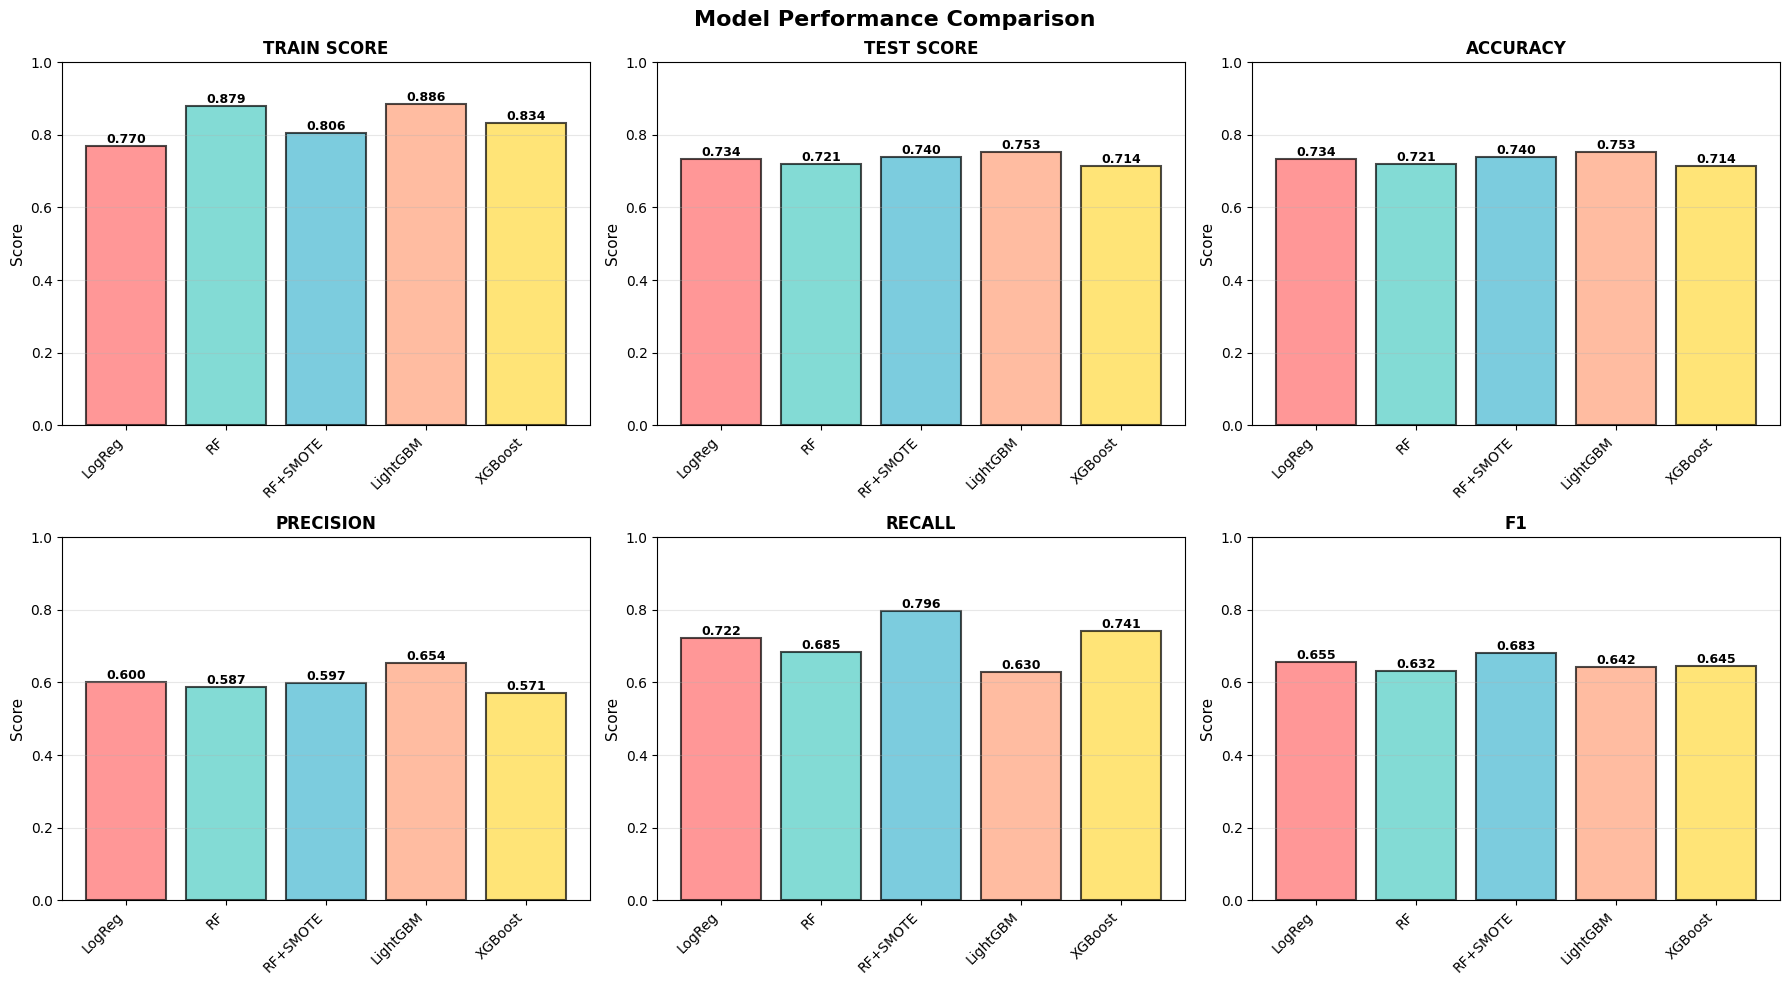


최고 성능 모델 분석

 ▶ F1 기준 최고 모델: RF+SMOTE
   - F1 Score: 0.6825
   - Test Accuracy: 0.7403
   - ROC-AUC: 0.8270

 ▶ 테스트 정확도 기준 최고 모델: LightGBM
   - Test Accuracy: 0.7532
   - F1 Score: 0.6415
   - ROC-AUC: 0.8219

모델별 성능 순위 (F1 Score)
1. RF+SMOTE        - F1: 0.6825, Test Acc: 0.7403, ROC-AUC: 0.8270
2. LogReg          - F1: 0.6555, Test Acc: 0.7338, ROC-AUC: 0.8100
3. XGBoost         - F1: 0.6452, Test Acc: 0.7143, ROC-AUC: 0.8222
4. LightGBM        - F1: 0.6415, Test Acc: 0.7532, ROC-AUC: 0.8219
5. RF              - F1: 0.6325, Test Acc: 0.7208, ROC-AUC: 0.8161


In [17]:
# ------ 9. 결과 요약 및 시각화 ------
results_df = pd.DataFrame(results)

print("\n" + "="*80)
print("최종 모델 성능 비교")
print("="*80)
print(results_df.to_string(index=False))

# 성능 비교 시각화
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

metrics = ['train_score', 'test_score', 'accuracy', 'precision', 'recall', 'f1']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#FFD93D']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 3, idx % 3]
    bars = ax.bar(range(len(results_df)), results_df[metric], 
                   color=colors[:len(results_df)], alpha=0.7, edgecolor='black', linewidth=1.5)
    ax.set_title(metric.replace('_', ' ').upper(), fontsize=12, fontweight='bold')
    ax.set_ylabel('Score', fontsize=11)
    ax.set_xticks(range(len(results_df)))
    ax.set_xticklabels(results_df['model_name'], rotation=45, ha='right', fontsize=10)
    ax.set_ylim([0, 1])
    ax.grid(alpha=0.3, axis='y')
    
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height, f'{height:.3f}', 
                ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

# 최고 성능 모델
print("\n" + "="*80)
print("최고 성능 모델 분석")
print("="*80)

best_f1_idx = results_df['f1'].idxmax()
best_test_idx = results_df['test_score'].idxmax()

print(f"\n ▶ F1 기준 최고 모델: {results_df.loc[best_f1_idx, 'model_name']}")
print(f"   - F1 Score: {results_df.loc[best_f1_idx, 'f1']:.4f}")
print(f"   - Test Accuracy: {results_df.loc[best_f1_idx, 'test_score']:.4f}")
print(f"   - ROC-AUC: {results_df.loc[best_f1_idx, 'roc_auc']:.4f}")

print(f"\n ▶ 테스트 정확도 기준 최고 모델: {results_df.loc[best_test_idx, 'model_name']}")
print(f"   - Test Accuracy: {results_df.loc[best_test_idx, 'test_score']:.4f}")
print(f"   - F1 Score: {results_df.loc[best_test_idx, 'f1']:.4f}")
print(f"   - ROC-AUC: {results_df.loc[best_test_idx, 'roc_auc']:.4f}")

# 모델별 비교 요약
print("\n" + "="*80)
print("모델별 성능 순위 (F1 Score)")
print("="*80)
ranking = results_df.sort_values('f1', ascending=False)[['model_name', 'f1', 'test_score', 'roc_auc']]
for i, row in enumerate(ranking.itertuples(), 1):
    print(f"{i}. {row[1]:15s} - F1: {row[2]:.4f}, Test Acc: {row[3]:.4f}, ROC-AUC: {row[4]:.4f}")
